<a href="https://colab.research.google.com/github/groveratul/Recommendation-System/blob/master/rs_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommendation Systems

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip



### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from sklearn.model_selection import train_test_split
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
import scipy
import matplotlib.pyplot as plt

## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
 
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
   
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
       
        
        predictionMatrix = np.zeros((num_users, num_items))
       
        for (user,item), rating in np.ndenumerate(train_matrix):
        
          if rating == 0:
             
              userVector = train_matrix[user, :]
              
              
              ratedItems = userVector[userVector.nonzero()]
              
              if ratedItems.size == 0:
                  itemAvg = 0
              else:
                  itemAvg = ratedItems.mean()
              predictionMatrix[user, item] = itemAvg
              
          
          if (user % 100 == 0 and item == 1):
              print ("calculated %d users" % (user,))


        
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        
        
        predictionMatrix = np.zeros((num_users, num_items))
        
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
   
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            if rating == 0:
                predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))
              
       
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan

        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
            
        return prediction
        
    def getModel(self):
       
        return self.__model
    
    def getPredColName(self):
        
        return self.pred_column_name
    
    def reset(self):
        
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [02:07, 785.50it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:59, 837.32it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


https://stats.stackexchange.com/questions/158279/how-i-can-convert-distance-euclidean-to-similarity-score

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        
        similarity_matrix = 1  / (pairwise_distances(matrix,metric='euclidean') + 1)
        
    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        
        similarity_matrix = 1 / (pairwise_distances(matrix,metric='manhattan') + 1)
    

    
    
           
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
           
            
        elif self.base == 'item':
            
            train_matrix=train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            item_similarity = self.method(train_matrix)
            normalizer = np.matmul(item_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(item_similarity, train_matrix)/normalizer
             
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.transpose()
           
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        
        return self.__model
    
    def getPredColName(self):
        
        return self.pred_column_name
    
    def reset(self):
        
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:

I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

 Euclidean distance works better as it reduces recommendation problem to one of finding the nearest neighbors.

I have implemented manhattan distance as another metric because again it is similar to euclidean distance and it reduces recommendation problem to finding the nearest neighbor.(side effect is it effects to outliers)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [02:25, 689.00it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
       
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
       
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
algorithm_instances = [user_cosine_recsys , item_cosine_recsys]

In [0]:

cv_patk = CrossValidation('RMSE')

In [0]:

cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


20000it [00:11, 1809.24it/s]
20000it [00:10, 1889.53it/s]
20000it [00:10, 1869.52it/s]
20000it [00:10, 1880.16it/s]
20000it [00:10, 1906.95it/s]


Processing algorithm item-cosine


20000it [00:10, 1871.10it/s]
20000it [00:10, 1900.40it/s]
20000it [00:10, 1926.52it/s]
20000it [00:10, 1936.40it/s]
20000it [00:10, 1915.26it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.0264490128856898,
   1.0214387664092763,
   1.0132940323507253,
   1.009400399702741,
   1.0161883960008826],
  1.017354121469863,
  1.0090130800118484,
  1.0256951629278774]}

**3b:** User cosine performs better than item cosine because users
can predict other user's preferences more effectively while a user might like a certain movie of that genre or type while don't like that genre or type in whole.  

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  
        self.epsilon = epsilon  
        self._lambda = _lambda  
        self.momentum = momentum  
        self.maxepoch = maxepoch  
        self.num_batches = num_batches  
        self.batch_size = batch_size  
        self.w_Item = None  
        self.w_User = None  
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        
      
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  
        pairs_train = train_vec.shape[0] 
        

        num_user += 1  
        num_item += 1  
    
        self.epoch = 0
        
        self.w_Item = sqrt(0.1)*np.random.randn(num_item,self.num_feat)  
        self.w_User = sqrt(0.1)*np.random.randn(num_user,self.num_feat) 
        
    

        self.w_Item_inc = np.zeros((num_item, self.num_feat)) 
        self.w_User_inc = np.zeros((num_user, self.num_feat))  
        while self.epoch < self.maxepoch: 
            self.epoch += 1

         
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  

           
            for batch in range(self.num_batches): 
               

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                
                pred_out = np.sum(self.w_Item[batch_ItemID] * self.w_User[batch_UserID], axis=1)
                
            

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

              
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    
                    pred_out =  np.sum(self.w_Item[train_item_idx]*self.w_User[train_user_idx],axis=1) 
            

                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
            
                    pred_out = np.sum(self.w_Item[val_item_idx]*self.w_User[val_user_idx],axis=1)
            
            
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        
        return self.pred_column_name
    
    def reset(self):
        
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 17, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

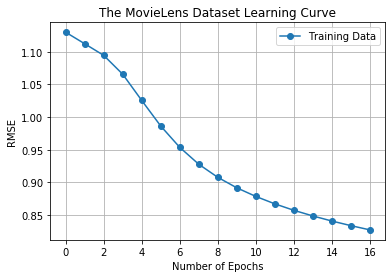

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

In [0]:
algorithm_instances = [item_cosine_recsys,
                       popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       pmf]

In [0]:
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')

In [0]:
result_patk = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
result_ratk = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)
result_rmse = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


20000it [00:10, 1924.70it/s]
20000it [00:10, 1966.36it/s]
20000it [00:10, 1987.93it/s]
20000it [00:10, 1978.43it/s]
20000it [00:10, 1995.34it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1932.60it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1964.71it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2019.98it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:09, 2001.12it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1990.09it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1996.43it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2007.77it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1990.63it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1953.18it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1974.27it/s]


Processing algorithm user-cosine


20000it [00:10, 1946.27it/s]
20000it [00:10, 1964.86it/s]
20000it [00:09, 2001.09it/s]
20000it [00:10, 1993.28it/s]
20000it [00:10, 1954.33it/s]


Processing algorithm PMF


20000it [00:19, 1042.11it/s]
20000it [00:19, 1037.64it/s]
20000it [00:20, 990.48it/s]
20000it [00:20, 998.18it/s]
20000it [00:19, 1016.37it/s]


Processing algorithm item-cosine


20000it [00:10, 1913.64it/s]
20000it [00:10, 1931.16it/s]
20000it [00:10, 1947.47it/s]
20000it [00:10, 1976.15it/s]
20000it [00:10, 1961.13it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1966.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1947.32it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1952.46it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1947.03it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1937.75it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1949.97it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1936.60it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1897.98it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1949.51it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1926.02it/s]


Processing algorithm user-cosine


20000it [00:10, 1908.81it/s]
20000it [00:10, 1918.76it/s]
20000it [00:10, 1969.67it/s]
20000it [00:10, 1960.55it/s]
20000it [00:10, 1935.89it/s]


Processing algorithm PMF


20000it [00:19, 1029.71it/s]
20000it [00:19, 1036.71it/s]
20000it [00:19, 1025.46it/s]
20000it [00:19, 1032.03it/s]
20000it [00:19, 1039.50it/s]


Processing algorithm item-cosine


20000it [00:10, 1918.92it/s]
20000it [00:10, 1921.07it/s]
20000it [00:10, 1977.43it/s]
20000it [00:10, 1981.84it/s]
20000it [00:10, 1949.50it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1953.92it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1968.41it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2002.24it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1982.33it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users


0it [00:00, ?it/s]

calculated 900 users


20000it [00:10, 1950.16it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1990.47it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1994.27it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2041.98it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2049.82it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:10, 1980.59it/s]


Processing algorithm user-cosine


20000it [00:10, 1976.09it/s]
20000it [00:09, 2016.74it/s]
20000it [00:09, 2005.27it/s]
20000it [00:10, 1972.21it/s]
20000it [00:10, 1992.01it/s]


Processing algorithm PMF


20000it [00:18, 1070.72it/s]
20000it [00:18, 1081.65it/s]
20000it [00:18, 1079.31it/s]
20000it [00:18, 1090.35it/s]
20000it [00:18, 1073.67it/s]


In [0]:
results = [result_patk,result_ratk,result_rmse]
metrics =["P@k" , "R@k" , "RMSE"]
for i in results:
  print( '\t \t \t \t \t \t {}'.format(metrics.pop(0)))
  print('________________________________________________________________________________________________________')
  print('|Algorithm \t|\t\t  Mean \t\t|\t\t\t  CI \t\t \t\t|')
  print('--------------------------------------------------------------------------------------------------------|')
  for keys,values in i.items():
    if keys != "PMF":
      print('|{0} \t|\t {1} \t|\t ({2},{3}) \t|'.format(keys, values[-3], values[-2],values[-1]))
    else:
      print('|{0} \t\t|\t {1} \t|\t ({2},{3})\t|'.format(keys, values[-3], values[-2],values[-1]))
  print('--------------------------------------------------------------------------------------------------------')
  print("\n \n")


	 	 	 	 	 	 P@k
________________________________________________________________________________________________________
|Algorithm 	|		  Mean 		|			  CI 		 		|
--------------------------------------------------------------------------------------------------------|
|item-cosine 	|	 0.5322163308589621 	|	 (0.3837005215009889,0.6807321402169354) 	|
|popularity 	|	 0.5505832449628855 	|	 (0.40544114481568705,0.6957253451100839) 	|
|useraverage 	|	 0.4736373276776259 	|	 (0.3419993013451059,0.6052753540101459) 	|
|user-cosine 	|	 0.5558430540827157 	|	 (0.40959849499983714,0.7020876131655943) 	|
|PMF 		|	 0.5444326617179229 	|	 (0.4029983920049023,0.6858669314309436)	|
--------------------------------------------------------------------------------------------------------

 

	 	 	 	 	 	 R@k
________________________________________________________________________________________________________
|Algorithm 	|		  Mean 		|			  CI 		 		|
-------------------------------------------------------

 I think popularity recommendation system can not be evaluated by RMSE because RMSE calculates the root mean square of popularity percentage doesn't make sense as shown in above output.

 For P@k and R@k : user cosine works the best because users cosine works on the correlation of rated users with other users and they are able to better generalise it better.

for RMSE : PMF works better because of parameter learning due to gradient descent.

 Good performance on RMSE does not imply good performance on ranking metrics and vice versa because position information that measures the ranking performance are not taking into account. Moreover the uncertainity of the prediction in rating oriented recommender system brings instability in RMSE based loss function.

*Cremonesi P, Koren Y, Turrin R. Performance of recommender algorithms on top-n recommendation tasks. In: Proceedings of the 4th ACM Conference on Recommender Systems. 2010, 39–46*



http://www.gregreda.com/2013/10/26/using-pandas-on-the-movielens-dataset/ took a little help from this

In [0]:
colnames=['movieID', 'movieTitle', 'releaseDate']
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names = colnames,usecols=range(3), encoding='latin-1')
train_matrix = dataPreprocessor(rating_df, num_users, num_items)

similarity_mat_item = SimBasedRecSys.cosine(train_matrix.T) # transpose because we are using item-item similarity


In [0]:
def similar(similarity_mat_item,ID,name,movies):
  vector = similarity_mat_item[ID-1]
  top5index = np.argsort(vector)[::-1][1:6]
  toprecommend=[]
  for i in top5index:
    toprecommend.append(movies.loc[movies['movieID'] == i, 'movieTitle'].iloc[0])
  print("Top 5 movies recommended by the item item cosine similarity for {} are:\n\n{} \n".format(name,toprecommend))

In [0]:
movies.head()

,movieID,movieTitle,releaseDate
0,1,Toy Story (1995),01-Jan-1995
1,2,GoldenEye (1995),01-Jan-1995
2,3,Four Rooms (1995),01-Jan-1995
3,4,Get Shorty (1995),01-Jan-1995
4,5,Copycat (1995),01-Jan-1995


In [0]:
similar(similarity_mat_item,568,"Speed (1994)",movies)
similar(similarity_mat_item,178,"12 Angry Men (1957)",movies)
similar(similarity_mat_item,272,"Good Will Hunting (1997)",movies)

Top 5 movies recommended by the item item cosine similarity for Speed (1994) are:

['Hudsucker Proxy, The (1994)', 'Naked Gun 33 1/3: The Final Insult (1994)', 'Glengarry Glen Ross (1992)', 'Free Willy (1993)', 'Aladdin (1992)'] 

Top 5 movies recommended by the item item cosine similarity for 12 Angry Men (1957) are:

['Nikita (La Femme Nikita) (1990)', 'Dead Poets Society (1989)', 'Henry V (1989)', 'Indiana Jones and the Last Crusade (1989)', 'Vertigo (1958)'] 

Top 5 movies recommended by the item item cosine similarity for Good Will Hunting (1997) are:

['3 Ninjas: High Noon At Mega Mountain (1998)', 'Midnight in the Garden of Good and Evil (1997)', 'Apt Pupil (1998)', 'Jackie Brown (1997)', 'Deceiver (1997)'] 



The similarities can be justified from the results. 

Speed is an Action Movie and most of the recommendations like naked gun and free willy are of crime and adventure genre.

12 Angry men is a drame movie based on the convition of a criminal. So,it is of  drama and action genre. As we can see from the recommendations: dead poet society , Indiana jones are from the same subsection of genre.

Good will Hunting is an Indie drama movie based on a janitor working in MIT which has a genius level IQ. As it is clear from the recommendations such as Deceiver and Midnight in the garden of good and Evil, the movies are from similar genre

In [0]:
newmatrix=np.zeros(train_matrix.shape)
newmatrix[train_matrix.nonzero()] = 1
newmatrix = np.sum(newmatrix, axis= 1 ) 
hist , bin_edges = scipy.histogram(newmatrix)
#got the highest value and just plotting the graph for further evaluation

(array([560., 183.,  96.,  55.,  25.,  15.,   5.,   1.,   1.,   2.]),
 array([ 20. ,  91.7, 163.4, 235.1, 306.8, 378.5, 450.2, 521.9, 593.6,
        665.3, 737. ]),
 <a list of 10 Patch objects>)

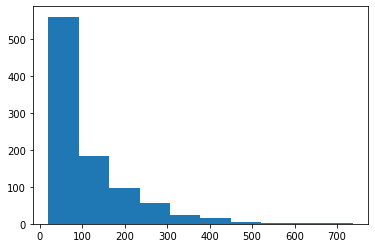

In [0]:
plt.hist(newmatrix)

threshold = 91 

We had to insert it again because in the original one, it was making a train matrix again from the train_df

In [0]:
def cosinemetric(train_matrix,base):
        
        
        
        if base == 'user':
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            
            useraverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            return predictionMatrix
            
        elif base == 'item':
            train_matrix=train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            item_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            normalizer = np.matmul(item_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            
            predictionMatrix = np.matmul(item_similarity, train_matrix)/normalizer
            
            itemaverage = np.sum(train_matrix, axis=1)/(np.sum(temp_matrix, axis=1) + 1e-5)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(itemaverage, axis=1)
            return predictionMatrix.transpose()
        else:
            print('No other option available')

def rmse(data ,pred):
        
        
        return sqrt(mean_squared_error(data[pred], data['rating']))

def evaluate_test(train_matrix, test_df ,base):
        
        copy=False
        pred_column_name = base+'-'+"cosine"
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, pred_column_name] = cosinemetric(train_matrix,'user')[userID-1, itemID-1]
    
        return prediction,pred_column_name

In [0]:
def thresholdRMSE( train_df , test_df,num_users,num_items,processor):
    train_matrix = processor(train_df, num_users, num_items)
    test_matrix = processor(test_df , num_users,num_items)
    threshold = 91
    traindata_abovethreshold = train_matrix[newmatrix >= threshold]
    traindata_belowthreshold = train_matrix[newmatrix < threshold]
    #testdata_abovethreshold = test_matrix[newmatrix >= threshold]
    #testdata_belowthreshold = test_matrix[newmatrix < threshold]
    pred_user_abovethreshold,uacol = evaluate_test(traindata_abovethreshold,test_df,'user')
    pred_user_belowthreshold,ubcol = evaluate_test(traindata_belowthreshold,test_df,'user')
    pred_item_abovethreshold,iacol = evaluate_test(traindata_abovethreshold,test_df,'item')
    pred_item_belowthreshold,ibcol = evaluate_test(traindata_belowthreshold,test_df,'item')
    rmse_user_abovethreshold = rmse(pred_user_abovethreshold,uacol)
    rmse_item_abovethreshold = rmse(pred_item_abovethreshold,iacol)
    rmse_user_belowthreshold = rmse(pred_user_belowthreshold,ubcol)
    rmse_item_belowthreshold = rmse(pred_item_belowthreshold,ibcol)
    print("Rmse for training data above thresehold for user-user collaborative filtering: {} \t|\nRmse for training data below thresehold for user-user collaborative filtering: {} \t|\nRmse for training data above thresehold for item-item collaborative filtering: {} \t|\nRmse for training data below thresehold for item-item collaborative filtering: {} \t|\n ".format(rmse_user_abovethreshold , rmse_user_belowthreshold, rmse_item_abovethreshold, rmse_item_belowthreshold))
    print("---------------------------------------------------------------------------------------------------------")

In [0]:

for i in range(1,6):
  thresholdRMSE(getData(MOVIELENS_DIR, 'u{}.base'.format(i)) ,getData(MOVIELENS_DIR, 'u{}.test'.format(i)),num_users,num_items,dataPreprocessor )


0it [00:00, ?it/s]
2it [00:00, 12.40it/s]
4it [00:00, 12.14it/s]
6it [00:00, 11.95it/s]
8it [00:00, 11.81it/s]
10it [00:00, 11.65it/s]
12it [00:01, 11.61it/s]
14it [00:01, 11.57it/s]
16it [00:01, 11.56it/s]
18it [00:01, 11.56it/s]
20it [00:01, 11.22it/s]
22it [00:01, 11.46it/s]
24it [00:02, 11.63it/s]
26it [00:02, 11.48it/s]
28it [00:02, 11.61it/s]
30it [00:02, 11.37it/s]
32it [00:02, 11.44it/s]
8678it [12:20, 12.31it/s]
36it [00:03, 11.42it/s]
38it [00:03, 11.33it/s]
40it [00:03, 11.36it/s]
42it [00:03, 10.77it/s]
44it [00:03, 10.84it/s]
46it [00:04, 10.97it/s]
48it [00:04, 10.90it/s]
50it [00:04, 11.08it/s]
52it [00:04, 11.14it/s]
54it [00:04, 11.00it/s]
56it [00:04, 10.90it/s]
58it [00:05, 10.89it/s]
60it [00:05, 10.86it/s]
62it [00:05, 10.87it/s]
64it [00:05, 10.93it/s]
66it [00:05, 10.83it/s]
68it [00:06, 10.83it/s]
70it [00:06, 10.93it/s]
72it [00:06, 10.92it/s]
74it [00:06, 10.78it/s]
76it [00:06, 10.59it/s]
78it [00:07, 10.74it/s]
80it [00:07, 10.91it/s]
82it [00:07, 10.81it/s

 Upper threshold works better for every different dataset and I think it is because users with more ratings show a better trend or behaviour and help in better correlation then users with less ratings.